# Batching Hyper-parameter Tuning jobs (CPU)

In this notebook, we demonstrate how to batch hyper-parameter tuining jobs using a batching strategy valid for both Bayesian and Random Optimization. We will cover both cold and warm start examples using PyTorch.

Topics Covered in this notebook:

1. SageMaker Hyper-parameter Optimization with PyTorch
2. Batching Large-scale HPO jobs

Required Infrastructure: We will run this notebook using the PyTorch 1.6 Python 3.6 CPU Optimized kernel.

We will use a credit card default dataset from UCI published here: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients for our example.

*Note*: In the code folder, we have also provided files train.py, and train_ray.py which are designed to work on GPU instances. We provide documentation on any other changes you need to make to use GPU instances below. 


## Import Libraries

Here you import the necessary libraries we need in order to run the code in the cells.

In [1]:
import sys
import IPython
install_needed = True  # should only be True once
if install_needed:
    print("installing deps and restarting kernel")
    !{sys.executable} -m pip install -U sagemaker
    !{sys.executable} -m pip install -U smdebug
    !{sys.executable} -m pip install -U bokeh
    !{sys.executable} -m pip install -U xlrd
    IPython.Application.instance().kernel.do_shutdown(True)

installing deps and restarting kernel
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 96 kB 490 kB/s  eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [8]:
import csv
import glob
import math
import os
import shutil
from time import gmtime, sleep, strftime, time
from botocore.config import Config
import boto3
import numpy as np
import pandas as pd
from sklearn.utils import resample
from smdebug.profiler.analysis.notebook_utils.timeline_charts import \
    TimelineCharts
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

import sagemaker
from sagemaker.analytics import ExperimentAnalytics
from sagemaker.debugger import (FrameworkProfile, ProfilerConfig, ProfilerRule,
                                Rule, rule_configs)
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (CategoricalParameter, ContinuousParameter,
                             HyperparameterTuner, IntegerParameter,
                             WarmStartConfig, WarmStartTypes)
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent

In [9]:
sm = boto3.client('sagemaker', config=Config(retries={'max_attempts': 20}))
sagemaker_session = sagemaker.Session(sagemaker_client=sm)

bucket = sagemaker_session.default_bucket()
prefix = 'distributed_hpo/DEMO-pytorch-hpo'

role = sagemaker.get_execution_role()
region = boto3.session.Session().region_name
print(f'region is {region}')

region is us-east-1


## The Dataset

For this notebook, we will use a Credit Card Default Dataset published by UCI: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients. Here we provide the dataset as part of the code in this notebook. 

This will be sufficient for testing out the SageMaker features above. 

In [4]:
if not os.path.exists('./data'):
    os.mkdir('./data')
else:
    pass

### Load the dataset

In [5]:
df1 = pd.read_excel('credit_card_default_data.xls', header=1)
df1 = df1.drop(columns = 'ID')
#rename the defaults column
df1.rename(columns={"default payment next month": "Default"}, inplace=True)
df1.to_csv('./data/data.csv', index=False)
df1.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
df1.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
Default      int64
dtype: object

## Data Pre-processing

In this section we will shuffle and split the data into train and test and explore the dataset

<AxesSubplot:>

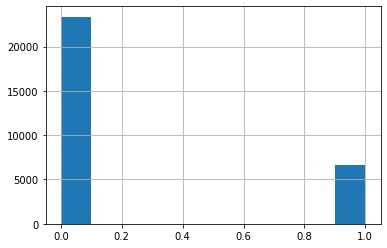

In [7]:
# histgram of the number of defaults versus not
df1.Default.hist()

In [8]:
df1.Default.value_counts()

0    23364
1     6636
Name: Default, dtype: int64

In [29]:
# Make train folder

if not os.path.exists('./train'):
    os.mkdir('./train')
else:
    pass

# make test folder 

if not os.path.exists('./test'):
    os.mkdir('./test')
else:
    pass

### Train-test split

Split the raw data into train and test sets. Since the number of foreclosures is very small, we will oversample the training dataset to balance the number of defaulted and non-defaulted loans in the training dataset. Note that this can introduce training/serving skew -- to avoid this, we will prepare a separate test set, derived from the test data which retains the original distribution. The model will be validated against this test set after every training epoch.


In [39]:
def train_test_split(file):
    df = pd.read_csv('./data/'+file)
    train=df.sample(frac=0.8,random_state=200) #random state is a seed value
    test=df.drop(train.index)
    print(f'Original training before upsampling shape = ......{train.shape}')
    # first upsample the minority class in training dataset
    train_majority = train[train.Default==0]
    train_minority = train[train.Default==1]
    train_minority_upsampled = resample(train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(train_majority),    # Experiment with this on your own to see if it improves accuracy.
                                 random_state=123) # reproducible results
 
    # Combine majority class with upsampled minority class
    train_upsampled = pd.concat([train_majority, train_minority_upsampled], axis=0)
    train_upsampled=train_upsampled.sample(frac=1) #shuffle the data
    print(f"Train file shape = .....{train_upsampled.shape}")
    print(f"Test file shape = .....{test.shape}")
    train_upsampled.to_csv(f'./train/{file}', index=False, header=True)
    test.to_csv(f'./test/{file}', index=False, header=True)
    return len(train_upsampled), len(test)

In [40]:
total_train_rows = 0
total_test_rows = 0
for file in os.listdir('./data'): #this will work if you have multiple data files as well. 
    print(file)
    trl, tel = train_test_split(file)
    total_test_rows+=tel
    total_train_rows+=trl
print(f"Total Training Loans ={total_train_rows}")
print(f"Total Testing Loans = {total_test_rows}")

data.csv
Original training before upsampling shape = ......(24000, 24)
Train file shape = .....(37266, 24)
Test file shape = .....(6000, 24)
Total Training Loans =37266
Total Testing Loans = 6000


### Shard the dataset into smaller files

In order for PyTorch to train faster, it is recommended to shard your large dataest into much smaller files. This way the PyTorch dataloader can quickly load one csv at a time consisting of N rows and train the model on that batch. 

The code below will read in each line from the primary dataframe line by line and store it in a separate dataframe. 

Then we will repeat this for the test set.

In [41]:
if not os.path.exists('./train_full_split'):
    os.mkdir('./train_full_split')
else:
    pass

In [43]:
# split the training data into smaller files that can be loaded using the data loader
COLS = pd.read_csv('./train/data.csv').columns
csvfile = open('./train/data.csv', 'r').readlines()
filename = 1
for i in range(len(csvfile)):
    if i % 10000 == 0:
        with open('./train_full_split/' + str(filename) + '.csv', 'w+') as f:
            if filename == 1:
                f.writelines(csvfile[i:i+10000])
            else:
                writer = csv.writer(f, delimiter=',')
                writer.writerow(COLS)
                f.writelines(csvfile[i:i+10000])
        filename += 1
       

In [44]:
if not os.path.exists('./test_full_split'):
    os.mkdir('./test_full_split')
else:
    pass

In [45]:
# split the training data into smaller files that can be loaded using the data loader
csvfile = open('./test/data.csv', 'r').readlines()
filename = 1
for i in range(len(csvfile)):
    if i % 10000 == 0:
        with open('./test_full_split/' + str(filename) + '.csv', 'w+') as f:
            if filename == 1:
                f.writelines(csvfile[i:i+10000])
            else:
                writer = csv.writer(f, delimiter=',')
                writer.writerow(COLS)
                f.writelines(csvfile[i:i+10000])
        filename += 1
       

### Upload Training and test datasets to S3

In [10]:
#Upload Training and test data into S3
train_s3 = sagemaker_session.upload_data(path='./train_full_split/', key_prefix=prefix + '/train')
print(train_s3)
test_s3 = sagemaker_session.upload_data(path='./test_full_split/', key_prefix=prefix + '/test')
print(test_s3)

s3://sagemaker-us-east-1-389535300735/distributed_hpo/DEMO-pytorch-hpo/train
s3://sagemaker-us-east-1-389535300735/distributed_hpo/DEMO-pytorch-hpo/test


## Training Script

Here we author our training script which we will use for parallel HPO. This train script uses the SageMaker Distributed DataParallel class for PyTorch for distributed training. 

We will also use SageMaker Profiler to obtain metrics associated with the training job such as the CPU/GPU usage. This is particularly useful for large scale deep learning training jobs.

### 1. Create a Training Job with Profiling Enabled<a class="anchor" id="option-1"></a>

You will use the standard [SageMaker Estimator API for PyTorch ](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.pytorch.html) to create training jobs. To enable profiling, create a `ProfilerConfig` object and pass it to the `profiler_config` parameter of the `PyTorch` estimator.

### 2. Use SM Distributed DataParallel (DDP) to effiently parallelize the training job across multiple GPUs. 

The training script provides the code you need for distributed data parallel (DDP) training using SMDataParallel. The training script is very similar to a PyTorch training script you might run outside of SageMaker, but modified to run with SMDataParallel. SMDataParallel's PyTorch client provides an alternative to PyTorch's native DDP. For details about how to use SMDataParallel's DDP in your native PyTorch script, see the Getting Started with SMDataParallel tutorials.

For your benefit, we have provided 2 training scripts:

1. train.py : full training script with SM DDP and SageMaker Profiler

2. train_profiler.py : training script with regular PyTorch DDP and SageMaker Profiler

In [12]:
!pygmentize code/train_cpu.py

import argparse
import glob
import json
import logging
import os
import sys

import pandas as pd
import torch
import torch.autograd.profiler as profiler
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data.distributed
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

class LoansPredictionDataset(Dataset):
    """LoanPredictionDataset."""

    def __init__(self, root_dir):
        """Initializes instance of class LoanPredictionDataset.

        Args:
            csv_file (str): Path to the csv files with the loan data.

        """
        self.paths =  glob.glob(root_dir + "/*.csv")
        self.target = 'Default'
        # Grouping variable names

    def __len__(self):
    

### Train the model. 

To train the model, we will now use 2 GPUs and also use SageMaker Profiler Capability to generate a report of the GPU utilization, and other performance metrics.

#### Estimator function options
In the following code block, you can update the estimator function to use a different instance type, instance count, and distrubtion strategy. You're also passing in the training script you reviewed in the previous cell.

**Instance types**

SMDataParallel supports model training on SageMaker with the following instance types only:
ml.p3.16xlarge
ml.p3dn.24xlarge [Recommended]
ml.p4d.24xlarge [Recommended]

**Instance count**
To get the best performance and the most out of SMDataParallel, you should use at least 2 instances, but you can also use 1 for testing this example.
Distribution strategy
Note that to use DDP mode, you update the the distribution strategy, and set it to use smdistributed dataparallel.

**Code folder**

In order to run SM DistributedDataParallel, we need to ensure our training container has the latest version of the SageMaker SDK. To do this, simply pass in a requirements.txt file along with your code script in the code folder as provided here. We pass in the code folder as the source directory, pointing to the training script. 

**SageMaker Experiments**

We will also track the training jobs using SageMaker Experiments, which will allow data scientist to compare different trials, analyze and extract any metadata from their training runs and compare jobs.

This is particularly useful with HPO, when data scientists want to compare different Hyperparameter tuning jobs against one another.

In [14]:
loan_class_experiment = Experiment.create(
    experiment_name=f"Classifying-housing-loans-{int(time())}",
    description="Classification of loans as default or not", 
    sagemaker_boto_client=sm)
print(loan_class_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7fb52a669160>,experiment_name='Classifying-housing-loans-1610551033',description='Classification of loans as default or not',tags=None,experiment_arn='arn:aws:sagemaker:us-east-1:389535300735:experiment/classifying-housing-loans-1610551033',response_metadata={'RequestId': '5737d0ff-c572-4469-af8b-5a26df1d5ce7', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '5737d0ff-c572-4469-af8b-5a26df1d5ce7', 'content-type': 'application/x-amz-json-1.1', 'content-length': '108', 'date': 'Wed, 13 Jan 2021 15:17:13 GMT'}, 'RetryAttempts': 0})


In [22]:
# Now let's launch a SageMaker training job on  p3 instance. Next we will run a HPO job.
trial_name = f"loan-trial-base-{int(time())}"
loan_trial = Trial.create(
        trial_name=trial_name,
        experiment_name=loan_class_experiment.experiment_name,
        sagemaker_boto_client=sm,
    )

estimator = PyTorch(entry_point="train_cpu.py", 
                    role=role,
                    framework_version='1.6.0',
                    py_version='py36',
                    source_dir='./code',
                    output_path = f's3://{bucket}/{prefix}/output',
                    instance_count=1, 
                    sagemaker_session=sagemaker_session,
                    instance_type='ml.m5.xlarge', 
                    hyperparameters={
                        'epochs': 3,
                        'backend': 'gloo' #gloo for CPU, nccl for GPU
                    },
                  # allows Experiments to capture metrics  
                    metric_definitions=[
                        {'Name':'train:loss', 'Regex':'Train Loss: (.*?);'},
                        {'Name':'test:loss', 'Regex':'Test set Average loss: (.*?),'},
                        {'Name':'test:accuracy', 'Regex':'Test Accuracy: (.*?)%;'},
                        {'Name':'test:F1', 'Regex':'Test set F1-score: (.*?),'}
                    ]
            )

# this is a fire and forget event -- this way you can continue to use the notebook below for other data exploration
# and prototyping activities. 

estimator.fit({'training': train_s3,
                'testing':test_s3},
              experiment_config={
            "TrialName": loan_trial.trial_name,
            "TrialComponentDisplayName": "Training",
        },
             wait=False)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: pytorch-training-2021-01-13-16-04-12-404


2021-01-13 16:04:12 Starting - Starting the training job...
2021-01-13 16:04:37 Starting - Launching requested ML instancesProfilerReport-1610553852: InProgress
......
2021-01-13 16:05:38 Starting - Preparing the instances for training...
2021-01-13 16:06:12 Downloading - Downloading input data......
2021-01-13 16:07:04 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-01-13 16:07:05,123 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-01-13 16:07:05,126 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-01-13 16:07:05,135 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-01-13 16:07:05,142 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-01-13 16:07:19,717 sagemaker-training-toolkit INFO     Ins

### Run the training job on a GPU

To test this estimator out with the latest smdistributed library, make the following changes:

1. replace entry_point = "train.py"

2. add the following code in "" after metric_definitions: "distribution={'smdistributed':{
                                            'dataparallel':{
                                                    'enabled': True
                                                 }
                                          }
                                     },"
 
 
3. In hyperparameters, replace 'backend': 'nccl'

This will instantiate the sm distributed library on the containers. To learn more about Sm distributed, see this link: 
https://aws.amazon.com/sagemaker/distributed-training/



### Algorithm metrics

We want to extract the model metrics on the test set. To do this, we will use the SageMaker Experiments API and extract the metric for the trail above. 

In [23]:
from sagemaker.analytics import ExperimentAnalytics
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=sagemaker_session, 
    experiment_name=loan_class_experiment.experiment_name,
    metric_names=['test:F1']
)
analytic_table = trial_component_analytics.dataframe()
analytic_table

,TrialComponentName,DisplayName,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,backend,epochs,sagemaker_container_log_level,...,testing - MediaType,testing - Value,training - MediaType,training - Value,SageMaker.DebugHookOutput - MediaType,SageMaker.DebugHookOutput - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value,Trials,Experiments
0,pytorch-training-2021-01-13-16-04-12-404-aws-t...,Training,arn:aws:sagemaker:us-east-1:389535300735:train...,763104351884.dkr.ecr.us-east-1.amazonaws.com/p...,1.0,ml.m5.xlarge,30.0,"""gloo""",3.0,20.0,...,None,s3://sagemaker-us-east-1-389535300735/distribu...,None,s3://sagemaker-us-east-1-389535300735/distribu...,None,s3://sagemaker-us-east-1-389535300735/distribu...,None,s3://sagemaker-us-east-1-389535300735/distribu...,[loan-trial-base-1610553852],[Classifying-housing-loans-1610551033]
1,pytorch-training-2021-01-13-15-54-42-229-aws-t...,Training,arn:aws:sagemaker:us-east-1:389535300735:train...,763104351884.dkr.ecr.us-east-1.amazonaws.com/p...,1.0,ml.m5.xlarge,30.0,"""gloo""",3.0,20.0,...,None,s3://sagemaker-us-east-1-389535300735/distribu...,None,s3://sagemaker-us-east-1-389535300735/distribu...,None,s3://sagemaker-us-east-1-389535300735/distribu...,None,s3://sagemaker-us-east-1-389535300735/distribu...,[loan-trial-base-1610553282],[Classifying-housing-loans-1610551033]
2,pytorch-training-2021-01-13-15-47-51-045-aws-t...,Training,arn:aws:sagemaker:us-east-1:389535300735:train...,763104351884.dkr.ecr.us-east-1.amazonaws.com/p...,1.0,ml.m5.xlarge,30.0,"""gloo""",3.0,20.0,...,None,s3://sagemaker-us-east-1-389535300735/distribu...,None,s3://sagemaker-us-east-1-389535300735/distribu...,None,s3://sagemaker-us-east-1-389535300735/distribu...,None,s3://sagemaker-us-east-1-389535300735/distribu...,[loan-trial-base-1610552870],[Classifying-housing-loans-1610551033]
3,pytorch-training-2021-01-13-15-36-03-172-aws-t...,Training,arn:aws:sagemaker:us-east-1:389535300735:train...,763104351884.dkr.ecr.us-east-1.amazonaws.com/p...,1.0,ml.m5.xlarge,30.0,"""gloo""",3.0,20.0,...,None,s3://sagemaker-us-east-1-389535300735/distribu...,None,s3://sagemaker-us-east-1-389535300735/distribu...,None,s3://sagemaker-us-east-1-389535300735/distribu...,None,s3://sagemaker-us-east-1-389535300735/distribu...,[loan-trial-base-1610552163],[Classifying-housing-loans-1610551033]
4,pytorch-training-2021-01-13-15-26-08-344-aws-t...,Training,arn:aws:sagemaker:us-east-1:389535300735:train...,763104351884.dkr.ecr.us-east-1.amazonaws.com/p...,1.0,ml.m5.xlarge,30.0,"""gloo""",3.0,20.0,...,None,s3://sagemaker-us-east-1-389535300735/distribu...,None,s3://sagemaker-us-east-1-389535300735/distribu...,None,s3://sagemaker-us-east-1-389535300735/distribu...,None,s3://sagemaker-us-east-1-389535300735/distribu...,[loan-trial-base-1610551568],[Classifying-housing-loans-1610551033]
5,pytorch-training-2021-01-13-15-17-14-722-aws-t...,Training,arn:aws:sagemaker:us-east-1:389535300735:train...,763104351884.dkr.ecr.us-east-1.amazonaws.com/p...,1.0,ml.m5.xlarge,30.0,"""gloo""",3.0,20.0,...,None,s3://sagemaker-us-east-1-389535300735/distribu...,None,s3://sagemaker-us-east-1-389535300735/distribu...,None,s3://sagemaker-us-east-1-389535300735/distribu...,None,s3://sagemaker-us-east-1-389535300735/distribu...,[loan-trial-base-1610551034],[Classifying-housing-loans-1610551033]


In [66]:
# get details for most recent job:
analytic_table.iloc[0]

TrialComponentName                            pytorch-training-2021-01-11-20-03-47-090-aws-t...
DisplayName                                                                            Training
SourceArn                                     arn:aws:sagemaker:us-east-1:389535300735:train...
SageMaker.ImageUri                            763104351884.dkr.ecr.us-east-1.amazonaws.com/p...
SageMaker.InstanceCount                                                                       1
SageMaker.InstanceType                                                           ml.p3.16xlarge
SageMaker.VolumeSizeInGB                                                                     30
backend                                                                                  "nccl"
epochs                                                                                        5
sagemaker_container_log_level                                                                20
sagemaker_distributed_dataparallel_enabl

# Scaling to Tens of thousands of HPO jobs

Having seen how we can launch 1 job, next we will look at some strategies for scaling this to tens of thousands of jobs with Amazon SageMaker for both random and bayesian HPO methods that are come out-of-the-box with SageMaker. 

Currently, for Bayesian HPO, SageMaker has a limit of 500 *concurrent* jobs across all Bayesian HPO jobs. Below we will provide code for launching the maximum possible Bayesian trials while respecting this limit.

Let's look at both strategies in detail. 

## Random Strategy

For random strategy, each trial in an HPO job is completely independent of one another. In this case, if we want to launch a total of N_tot jobs, we can choose to launch N HPO jobs concurrently with each HPO job having M parallel jobs.

To see how you can launch multiple HPO jobs in parallel, refer to the code below.

## Batched Hyper-parameter Optimization for Bayesian Optimization (Cold Start)

For Bayesian HPO, we want to take advantage of the parallelism by training multiple hyper-parameter trials in parallel so the Bayesian algorithm can use the outputs of these parallel jobs to determine the next set of parameters.

Again we are limited by the number of concurrent jobs/account = 500, and the default limits are 10 jobs in parallel per job. In that case we can adapt the formula above as follows:

![Visual Representation of Batching jobs](img/batching.png)


In [11]:
def bayesian_batching_cold_start(total_requested_trials, max_parallel_across_jobs=20, max_parallel_per_job=10, max_candidates_per_job = 500):
    '''Given a total number of requested trials, generates the strategy for Bayesian HPO
    The strategy is a list (batch_strat) where every element is the number of jobs to execute in parallel. The sum of all elements in the list is
    the total number of HPO jobs needed to reach total_requested_trials. For example if batch_strat = [2, 2, 2, 1], means you will run a total of 7
    HPO jobs starting with 2 --> 2 ---> 2 ---> 1. 
    total_requested_trials = number of trails user wants to run.
    max_parallel_across_jobs = max number of training jobs across all trials Sagemaker runs in parallel. Limited by instance availability
    max_parallel_per_job = max number of parallel jobs to run per HPO job
    max_candidates_per_job = total number of training jobs per HPO job'''
    batch_strat = [] 
    tot_jobs_left = total_requested_trials
    max_parallel_hpo_jobs = max_parallel_across_jobs//max_parallel_per_job
    if total_requested_trials < max_parallel_hpo_jobs*max_candidates_per_job:
        batch_strat.append(total_requested_trials//max_candidates_per_job)
    else:
        while tot_jobs_left > max_parallel_hpo_jobs*max_candidates_per_job:
            batch_strat.append(max_parallel_hpo_jobs)
            tot_jobs_left -=max_parallel_hpo_jobs*max_candidates_per_job

        batch_strat.append(math.ceil((tot_jobs_left)/max_candidates_per_job))
    return math.ceil(total_requested_trials/max_candidates_per_job), max_parallel_hpo_jobs, batch_strat
                
bayesian_batching_cold_start(10000)

(20, 2, [2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [12]:
# let's redefine a simpler estimator with just 1 instance. 
hyperparameter_ranges = {'lr': ContinuousParameter(0.001, 0.1),
                         'momentum': CategoricalParameter(list(np.arange(0, 10)/10))}

inputs ={'training': train_s3,
         'testing':test_s3}

objective_metric_name = 'test AUC'
objective_type = 'Maximize'
metric_definitions = [{'Name': 'test AUC',
                       'Regex': 'Test set AUC: ([0-9\\.]+)'}]


In [13]:
# Create  the estimator for HPO
estimator = PyTorch(entry_point="train_cpu.py",
                    role=role,
                    framework_version='1.6.0',
                    py_version='py36',
                    source_dir='./code',
                    output_path = f's3://{bucket}/{prefix}/output',
                    instance_count=1, 
                    sagemaker_session=sagemaker_session,
                    instance_type='ml.m5.xlarge', 
                    hyperparameters={
                        'epochs': 10, # run more epochs for HPO.
                        'backend': 'gloo' #gloo for cpu, nccl for gpu
                    }
            )

### Run the HPO job on a GPU

As before, to run this HPO job using a GPU and test out the SM distributed library on large scale datasets, make the following code changes.


1. replace entry_point = "train.py"

2. add the following code in "" after metric_definitions: "distribution={'smdistributed':{
                                            'dataparallel':{
                                                    'enabled': True
                                                 }
                                          }
                                     },"
 
 
3. In hyperparameters, replace 'backend': 'nccl'

This will instantiate the sm distributed library on the containers. To learn more about Sm distributed, see this link: 
https://aws.amazon.com/sagemaker/distributed-training/

### Polling jobs
You can potentially reduce your overall wall time by polling continuously for completed HPO jobs. This way, if the number of launched HPO jobs is less than a certain threshold, you can start a new one. Use the code below to implement the polling strategy.

In [31]:
# helper function to launch a desired number of "n_parallel" HPO jobs simultaneously
def _parallel_hpo_no_polling(job_name_prefix, n_parallel, inputs, max_candidates_per_job, max_parallel_per_job):
    """kicks off N_parallel Bayesian HPO jobs in parallel
    job_name_prefix: user specified prefix for job names
    n_parallel: Number of HPO jobs to start in parallel
    inputs: training and test data s3 paths
    max_candidates_per_job: number of training jobs to run in each HPO job in total
    max_parallel_per_job: number of training jobs to run in parallel in each job
    
    """
    # kick off n_parallel jobs simultaneously and returns all the job names 
    tuning_job_names = []
    for i in range(n_parallel):
        timestamp_suffix = strftime("%d-%H-%M-%S", gmtime())
        try:
            tuner = HyperparameterTuner(estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs=max_candidates_per_job,
                            max_parallel_jobs=max_parallel_per_job,
                            base_tuning_job_name=f'{job_name_prefix}-{timestamp_suffix}',
                            objective_type=objective_type)
        # fit the tuner to the inputs and include it as part of experiments
            tuner.fit(inputs, 
                  wait=False) # set wait=False, so you can launch other jobs in parallel.
            tuning_job_names.append(tuner.latest_tuning_job.name)
            sleep(1) #this is required otherwise you will get an error for using the same tuning job name
            print(tuning_job_names)
        except Exception as e:
            sleep(5)
    return tuning_job_names

#orchestration and polling logic
def poll_and_run(job_name_prefix, inputs, max_total_candidates, max_parallel_across_jobs, max_candidates_per_job, max_parallel_per_job):
    """Polls for number of running HPO jobs. If less than max_parallel , starts a new one. 
    job_name_prefix: the name prefix to give all your training jobs
    max_total_candidates: how many total trails to run across all HPO jobs
    max_candidates_per_job: how many total trails to run for 1 HPO job 
    max_parallel_per_job: how many trials to run in parallel for a given HPO job (fixed to 10 without limit increases). 
    max_parallel_across_jobs: how many concurrent trials to run in parallel across all HPO jobs
    """
    #get how many jobs to run in total and concurrently
    max_num, max_parallel, _ = bayesian_batching_cold_start(max_total_candidates, 
                                                            max_parallel_across_jobs=max_parallel_across_jobs,
                                                            max_parallel_per_job=max_parallel_per_job,
                                                            max_candidates_per_job = max_candidates_per_job
                                                           )
    
    # continuously polls for running jobs -- if they are less than the required number, then launches a new one. 
    try:
        all_jobs = sm.list_hyper_parameter_tuning_jobs(SortBy='CreationTime', SortOrder='Descending', 
                                                       NameContains=job_name_prefix)['HyperParameterTuningJobSummaries']
        all_jobs = [i['HyperParameterTuningJobName'] for i in all_jobs]

        if len(all_jobs)==0:
            raise ValueError
        
        else:
            print("Continuing where you left off...")
            response_list = [sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=i)['HyperParameterTuningJobStatus']
                         for i in all_jobs]
            num_left = max_num - response_list.count("Completed")
    except Exception as e:
        print(f"Starting a set of HPO jobs with the prefix {job_name_prefix} ...")
        num_left = max_num
        #kick off the first set of jobs
        all_jobs += _parallel_hpo_no_polling(job_name_prefix, min(max_parallel, num_left), inputs, max_candidates_per_job, max_parallel_per_job)
    
    
    while num_left >0:
        response_list = [sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=i)['HyperParameterTuningJobStatus']
                         for i in all_jobs]
        running_jobs = response_list.count("InProgress") # look for the jobs that are running. 
        print(f"number of completed jobs = {response_list.count('Completed')}")
        sleep(10)
        if running_jobs < max_parallel and len(all_jobs) < max_num:
            all_jobs += _parallel_hpo_no_polling(job_name_prefix, min(max_parallel-running_jobs, num_left), inputs, max_candidates_per_job, max_parallel_per_job)
        num_left = max_num - response_list.count("Completed")
                
    return all_jobs

In [ ]:
# Test out this loop
alljobs = poll_and_run('newtrials', inputs, max_total_candidates=260, max_parallel_across_jobs = 20, max_candidates_per_job=4, max_parallel_per_job=2)

Continuing where you left off...
number of completed jobs = 0


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-36-4-210114-1436
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


['newtrials-14-14-36-4-210114-1436']


INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-36-4-210114-1436
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-36-5-210114-1436
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-36-5-210114-1436


['newtrials-14-14-36-4-210114-1436', 'newtrials-14-14-36-5-210114-1436']


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-36-5-210114-1436
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-37-0-210114-1437
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-37-0-210114-1437


['newtrials-14-14-36-4-210114-1436', 'newtrials-14-14-36-5-210114-1436', 'newtrials-14-14-37-0-210114-1437']


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-37-1-210114-1437


['newtrials-14-14-36-4-210114-1436', 'newtrials-14-14-36-5-210114-1436', 'newtrials-14-14-37-0-210114-1437', 'newtrials-14-14-37-1-210114-1437']
number of completed jobs = 0


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-37-2-210114-1437
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-37-2-210114-1437


['newtrials-14-14-37-2-210114-1437']


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-37-2-210114-1437
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-37-3-210114-1437


['newtrials-14-14-37-2-210114-1437', 'newtrials-14-14-37-3-210114-1437']
number of completed jobs = 0


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-37-4-210114-1437
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-37-4-210114-1437


['newtrials-14-14-37-4-210114-1437']
number of completed jobs = 0


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-38-0-210114-1438


['newtrials-14-14-38-0-210114-1438']
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number of completed jobs = 0
number

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-44-5-210114-1444


['newtrials-14-14-44-5-210114-1444']
number of completed jobs = 1
number of completed jobs = 1
number of completed jobs = 2


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-45-2-210114-1445


['newtrials-14-14-45-2-210114-1445']
number of completed jobs = 2
number of completed jobs = 2
number of completed jobs = 2
number of completed jobs = 4


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-46-1-210114-1446
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-46-1-210114-1446


['newtrials-14-14-46-1-210114-1446']
number of completed jobs = 4


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-46-3-210114-1446


['newtrials-14-14-46-3-210114-1446']
number of completed jobs = 5


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-46-4-210114-1446


['newtrials-14-14-46-4-210114-1446']
number of completed jobs = 6


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-46-5-210114-1446


['newtrials-14-14-46-5-210114-1446']
number of completed jobs = 7


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-47-1-210114-1447


['newtrials-14-14-47-1-210114-1447']
number of completed jobs = 8


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-14-47-2-210114-1447


['newtrials-14-14-47-2-210114-1447']
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number of completed jobs = 8
number

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-15-03-3-210114-1503


['newtrials-14-15-03-3-210114-1503']
number of completed jobs = 18


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-15-03-5-210114-1503


['newtrials-14-15-03-5-210114-1503']
number of completed jobs = 18
number of completed jobs = 18
number of completed jobs = 19


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-15-04-2-210114-1504


['newtrials-14-15-04-2-210114-1504']
number of completed jobs = 19
number of completed jobs = 20


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-15-04-5-210114-1504


['newtrials-14-15-04-5-210114-1504']
number of completed jobs = 21


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-15-05-0-210114-1505


['newtrials-14-15-05-0-210114-1505']
number of completed jobs = 21
number of completed jobs = 22


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-15-05-2-210114-1505


['newtrials-14-15-05-2-210114-1505']
number of completed jobs = 23


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-15-05-4-210114-1505


['newtrials-14-15-05-4-210114-1505']
number of completed jobs = 24


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-15-05-5-210114-1505


['newtrials-14-15-05-5-210114-1505']
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
number of completed jobs = 24
num

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-15-12-5-210114-1512


['newtrials-14-15-12-5-210114-1512']
number of completed jobs = 25
number of completed jobs = 25
number of completed jobs = 27


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-15-13-3-210114-1513
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-15-13-3-210114-1513


['newtrials-14-15-13-3-210114-1513']
number of completed jobs = 27


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-15-13-5-210114-1513


['newtrials-14-15-13-5-210114-1513']
number of completed jobs = 28


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-15-14-0-210114-1514


['newtrials-14-15-14-0-210114-1514']
number of completed jobs = 29


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-15-14-2-210114-1514


['newtrials-14-15-14-2-210114-1514']
number of completed jobs = 29
number of completed jobs = 29
number of completed jobs = 30


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-15-15-0-210114-1515


['newtrials-14-15-15-0-210114-1515']
number of completed jobs = 31


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-15-15-1-210114-1515


['newtrials-14-15-15-1-210114-1515']
number of completed jobs = 31
number of completed jobs = 31
number of completed jobs = 31
number of completed jobs = 31
number of completed jobs = 31
number of completed jobs = 31
number of completed jobs = 32


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: newtrials-14-15-16-4-210114-1516


['newtrials-14-15-16-4-210114-1516']
number of completed jobs = 32
number of completed jobs = 32
number of completed jobs = 32
number of completed jobs = 32
number of completed jobs = 32
number of completed jobs = 32
number of completed jobs = 32
number of completed jobs = 32
number of completed jobs = 32
number of completed jobs = 32
number of completed jobs = 32
number of completed jobs = 32
number of completed jobs = 32
number of completed jobs = 32
number of completed jobs = 32
number of completed jobs = 32
number of completed jobs = 32
number of completed jobs = 32
number of completed jobs = 32
number of completed jobs = 32
number of completed jobs = 32
number of completed jobs = 32
number of completed jobs = 32
number of completed jobs = 32
number of completed jobs = 32


In [63]:
# Aggregate the results from all the HPO jobs based on the custom metric specified
def get_best_job(all_jobs_list):
    """Get the best job from the list of all the jobs completed.
    Objective is to maximize a particular value such as AUC or F1 score"""
    df = pd.DataFrame()
    for job in all_jobs_list:
        tuner = sagemaker.HyperparameterTuningJobAnalytics(job)
        full_df = tuner.dataframe()
        tuning_job_result = sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=job)
        is_maximize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] == 'Maximize')
        if len(full_df) > 0:
            df = pd.concat([df, full_df[full_df['FinalObjectiveValue'] < float('inf')]])
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_maximize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName
        return df
    else:
        print("No training jobs have reported valid results yet.")

In [64]:
get_best_job(alljobs)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.



Number of training jobs with valid objective: 8
{'lowest': 0.6139000058174133, 'highest': 0.6557999849319458}


,lr,momentum,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
2,0.001230,"""0.7""",hpotrails-13-18-23-4-210113-1823-002-9f95a3e9,Completed,0.6139,2021-01-13 18:26:17+00:00,2021-01-13 18:27:52+00:00,95.0
1,0.006406,"""0.0""",hpotrails-13-18-23-4-210113-1823-003-4aec77ff,Completed,0.6230,2021-01-13 18:30:10+00:00,2021-01-13 18:31:43+00:00,93.0
3,0.010226,"""0.0""",hpotrails-13-18-23-4-210113-1823-001-57d9d7fc,Completed,0.6318,2021-01-13 18:26:12+00:00,2021-01-13 18:27:46+00:00,94.0
1,0.002248,"""0.9""",hpotrails-13-18-22-4-210113-1822-003-5a57c9d6,Completed,0.6409,2021-01-13 18:29:47+00:00,2021-01-13 18:31:20+00:00,93.0
0,0.002353,"""0.9""",hpotrails-13-18-22-4-210113-1822-004-3a1a6c9b,Completed,0.6416,2021-01-13 18:29:20+00:00,2021-01-13 18:30:55+00:00,95.0
3,0.014784,"""0.7""",hpotrails-13-18-22-4-210113-1822-001-cc54b06a,Completed,0.6474,2021-01-13 18:25:11+00:00,2021-01-13 18:27:19+00:00,128.0
2,0.021520,"""0.8""",hpotrails-13-18-22-4-210113-1822-002-fef78ff9,Completed,0.6516,2021-01-13 18:25:16+00:00,2021-01-13 18:26:52+00:00,96.0
0,0.046496,"""0.9""",hpotrails-13-18-23-4-210113-1823-004-b8c4ad97,Completed,0.6558,2021-01-13 18:30:16+00:00,2021-01-13 18:32:05+00:00,109.0


The above example shows how the batching strategy works for cold-start cases. For warm start, we need a different strategy as we want to use the outputs of the previous job as the inputs into the next job. Look at the code below to run a warm start batch

## Serial Hyper-parameter Optimization (warm start)

For warm start -- we want to use the outputs of our previous run, as the input of the next one. For this reason, we need to run the jobs serially, as shown in the code below. 

In [291]:
def large_scale_hpo_warmstart(inputs, max_total_jobs, max_jobs_per_hpo_job, max_parallel_per_job):
    base_hpo_job_name = 'FTW'
    timestamp_suffix = strftime("%d-%H-%M-%S", gmtime())
    tuning_job_name = lambda i : f"{base_hpo_job_name}-{timestamp_suffix}-{i}"
    current_jobs_completed = 0
    job_names_list = []
    while current_jobs_completed < max_total_jobs:
        jobs_to_launch = min(max_total_jobs - current_jobs_completed, max_jobs_per_hpo_job)

        hpo_job_config = dict(
            estimator=estimator,
            objective_metric_name=objective_metric_name,
            metric_definitions=metric_definitions,
            hyperparameter_ranges=hyperparameter_ranges,
            max_jobs=jobs_to_launch,
            strategy="Bayesian",
            objective_type=objective_type,
            max_parallel_jobs=max_parallel_per_job,
        )

        if current_jobs_completed > 0:
            parent_tuning_job_name = tuning_job_name(current_jobs_completed)
            warm_start_config = WarmStartConfig(
                WarmStartTypes.IDENTICAL_DATA_AND_ALGORITHM,
                parents={parent_tuning_job_name}
            )
            hpo_job_config.update(dict(
                base_tuning_job_name=parent_tuning_job_name,
                warm_start_config=warm_start_config
            ))

        tuner = HyperparameterTuner(**hpo_job_config)
        tuner.fit(
            inputs,
            job_name=tuning_job_name(current_jobs_completed + jobs_to_launch),
            logs=True,
        )
        tuner.wait()
        job_names_list.append(tuner.latest_tuning_job.name)
        current_jobs_completed += jobs_to_launch
    return job_names_list

In [ ]:
job_list = large_scale_hpo_warmstart(inputs, 2, 1, 1)

.....................................................................................!
!
......................................................................................................................................................!
!


In [295]:
get_best_job(job_list)

True
True
Number of training jobs with valid objective: 2
{'lowest': 0.2502000033855438, 'highest': 0.3003999888896942}


,lr,momentum,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.005666,"""0.0""",FTW-10-22-37-49-2-001-7628c487,Completed,0.2502,2020-12-10 22:57:37+00:00,2020-12-10 23:07:59+00:00,622.0
0,0.002055,"""0.1""",FTW-10-22-37-49-1-001-6a2bdc3b,Completed,0.3004,2020-12-10 22:40:42+00:00,2020-12-10 22:52:16+00:00,694.0


## Conclusions

In this notebook we have covered a number of advanced topics suitable for ML researchers who run large scale deep learning training and HPO jobs.


1. We have covered how to run large numbers of HPO jobs using a continuous polling technique. 

2. We have provided code in the code folder to allow you to use the SM Distributed library as well as GPUs for faster training

3. Finally we covered how you can optimize for a custom metric, by publishing your custom metric to stdout and passing in the regex in the metric_definition during HPO.

## Optional Topic (using RayTune with PyTorch)

Ray is an open source library for HPO developed from this paper: https://arxiv.org/pdf/1807.05118.pdf our of UC Berkeley. Ray integrates with many of the popular open and closed source HPO search algorithms and schedulers. To see how Ray works with Amazon SageMaker, try out the estimator below which runs the train_ray.py script.


### Run the Ray job on a GPU

To test Ray with a single node GPU cluster, make the following code changes.

1. replace entry_point = "train_ray.py"

2. In hyperparameters, replace 'backend': 'nccl'

This will instantiate the sm distributed library on the containers. To learn more about Sm distributed, see this link: 
https://aws.amazon.com/sagemaker/distributed-training/

In [9]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train_ray_cpu.py", #put requirements.txt file to install ray
                    role=role,
                    source_dir='./code',
                    framework_version='1.6.0',
                    py_version='py3',
                    output_path = f's3://{bucket}/{prefix}/output',
                    instance_count=1,
                    instance_type='ml.m5.xlarge',
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'epochs': 7,
                        'backend': 'gloo' # gloo for CPU and nccl for GPU
                    },
                   disable_profiler=True)

inputs ={'training': train_s3,
         'testing':test_s3}

estimator.fit(inputs, wait=True)

INFO:sagemaker:Creating training-job with name: pytorch-training-2021-01-13-17-15-49-016


2021-01-13 17:15:49 Starting - Starting the training job...
2021-01-13 17:15:52 Starting - Launching requested ML instances.........
2021-01-13 17:17:24 Starting - Preparing the instances for training...
2021-01-13 17:18:01 Downloading - Downloading input data...
2021-01-13 17:18:49 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-01-13 17:18:49,658 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-01-13 17:18:49,661 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-01-13 17:18:49,673 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-01-13 17:18:51,098 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-01-13 17:18:51,476 sagemaker-training-toolkit INFO     Installing dependencies from requirement

## Conclusions

In this notebook, you have seen how to run large scale HPO jobs using SageMaker HPO tuning feature on a credit card default dataset. 

Wherever possible, with minimal code changes you can use this notebook to also use GPUs, as we have provided all the required code in the code folder associated with this repo. 

Happy Hyperparameter tuning!